# Text Classification Using Word Embeddings

## Introduction
We are going to use the Donors Choose dataset to classify text, determining if a teacher's proposal was accepted or rejected. Therefore we will be using binary classification techniques. Transforming the essays into numerical data by using pre-trained word embeddings. You need a pre-trained word embedding dataset, I used the Glove.50d dataset. Word embeddings capture the implicit relations between words by determining how often a word appears to other words in the training documents. In this case the embeddings are trained using articles from wikipedia.

In [94]:
%matplotlib inline  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from preprocessor_arc import Arc_preprocessor
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.preprocessing import OneHotEncoder
import string
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

Now some setup, defining the transformer that transforms the essay data into word embeddings. This will be done word by word, and then the word vectors will be averaged to find the document mean vector.

In [95]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []

        with open('/Users/aggarwalpiush/embeddings/offeneval_subtask_a.vec', 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        word_array = []
        for w in doc:
            if  w.lower().strip() in self._E:
                word_array.append(self._E[w.lower().strip()])
            else:
                word_array.append(np.zeros([len(v) for v in self._E.values()][0]))

        return np.mean(np.array(word_array), axis=0)
                
        #return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E else np.zeros([len(v) for v in self._E.values()][0])]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [133]:
def plot_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
def print_scores(clf, X_train, y_train, X_test, y_test, tweet_text):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(y_pred[:10])
    print(y_test[:10])
    print("prediction   gold  tweet")
    for i in range(len(y_pred)):
        if y_pred[i] != y_test[i]:
            for key, value in tweet_text.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
                if np.array_equal(value, X_test[i]):
                    print("%s\t%s\t%s" %(y_pred[i],y_test[i],key))
                    break
    print('Precision score: {:3f}'.format(precision_score(y_test, y_pred, average='macro') ))
    print('Recall score: {:3f}'.format(recall_score(y_test, y_pred, average='macro') ))
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred, average='macro')))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Metric : %s' %(confusion_matrix(y_test, y_pred)))
    print('Prediction Accuracy: {:3f}'.format(accuracy_score(y_test, y_pred)))

Loading the dataset using pandas

In [97]:
train_data = pd.read_csv('/Users/aggarwalpiush/github_repos/offensivetextevaluation/data/train_data_taskb/sub_taskb_train_data.tsv', sep='\t',
                        dtype={'tweet': object,  'id': np.int32,
                              'subtask_b': 'category'})
train_data.columns

Index(['id', 'tweet', 'subtask_b'], dtype='object')

In [98]:
train_data.head(3)


,id,tweet,subtask_b
0,86426,@USER She should ask a few native Americans wh...,UNT
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,TIN
2,62688,"@USER Someone should'veTaken"" this piece of sh...",UNT


We can see how much memory the dataset uses, it looks like it uses a bit, but small enough, so we'll save the transformed data to a file so it can be loaded faster.

In [6]:
train_data.memory_usage(deep=True).sum()

1132970

To determine if the dataset is unbalanced we can count the positive and negative cases. The number of positive cases is over five times the number of negative cases, which is very unbalanced, the AUC for the ROC curve or the F1 score would work fine for this dataset, but not regular accuracy.

In [5]:
train_data['subtask_b'].value_counts()

TIN    3876
UNT     524
Name: subtask_b, dtype: int64

In [99]:
X = train_data[['tweet']].values
y = train_data['subtask_b'].values
z = train_data[(train_data['subtask_b'] == 'TIN')][['tweet']].values
z_bar = train_data[(train_data['subtask_b'] != 'TIN')][['tweet']].values
print(X.shape)
print(z.shape)
print(z_bar.shape)

(4400, 1)
(3876, 1)
(524, 1)


In [100]:
y = train_data['subtask_b'].values

In [101]:
from collections import Counter
cnt = Counter(y)
print(cnt)

Counter({'TIN': 3876, 'UNT': 524})


In [102]:
def preprocessing_input(input_text):
    tweets = input_text
    arc_obj = Arc_preprocessor()
    tok_tweet = [arc_obj.tokenizeRawTweetText(doc) for doc in tweets]
    return tok_tweet


In [9]:
def one_hot_encoding(input_text, biased_text, assoc_measure, gram, threshold_value):
    table = str.maketrans('', '', string.punctuation)
    tok_tweet = preprocessing_input(biased_text)
    textWords = ' '.join([w.translate(table).lower() for w in [' '.join(doc) for doc in tok_tweet]]).split()
    textWords = [x  for x in textWords if not x.isdigit()]
    textWords = [x  for x in textWords if not x=='user']
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    if gram == 2:
        finder = BigramCollocationFinder.from_words(textWords)
        if assoc_measure == 'dice':
            scored = finder.score_ngrams(bigram_measures.dice)
        else:
            scored = finder.score_ngrams(bigram_measures.likelihood_ratio)
    else:
        finder = TrigramCollocationFinder.from_words(textWords)
        if assoc_measure == 'dice':
            scored = finder.score_ngrams(trigram_measures.dice)
        else:
            scored = finder.score_ngrams(trigram_measures.likelihood_ratio)
    n_gram_list = sorted([x for x,score in scored if score >= threshold_value])
    print(max([score for x,score in scored]))
    print(min([score for x,score in scored]))
    print([' '.join(x) for x in n_gram_list[:10]])
    print(len(n_gram_list))
    
    tok_train_text = preprocessing_input(input_text)
    embedding_size = len(n_gram_list)
    doc_length = len(tok_train_text)
    trainX = np.zeros((doc_length,embedding_size), dtype=int)
    for i,each_tw in enumerate(tok_train_text):
        textWord = ' '.join([w.translate(table).lower() for w in each_tw]).split()
        textWord = [x  for x in textWord if not x.isdigit()]
        textWord = [x  for x in textWord if not x=='user']
        bigrm = nltk.bigrams(textWord)
        for each_bigrm in bigrm:
            if each_bigrm in set(n_gram_list):
                trainX[i][n_gram_list.index(each_bigrm)] = 1
    return trainX
        
        
    
    
            
    

In [103]:
def dice_distribution( biased_text, assoc_measure, gram):
    table = str.maketrans('', '', string.punctuation)
    tok_tweet = preprocessing_input(biased_text)
    textWords = ' '.join([w.translate(table).lower() for w in [' '.join(doc) for doc in tok_tweet]]).split()
    textWords = [x  for x in textWords if not x.isdigit()]
    textWords = [x  for x in textWords if not x=='user']
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    trigram_measures = nltk.collocations.TrigramAssocMeasures()
    if gram == 2:
        finder = BigramCollocationFinder.from_words(textWords)
        if assoc_measure == 'dice':
            scored = finder.score_ngrams(bigram_measures.dice)
        else:
            scored = finder.score_ngrams(bigram_measures.likelihood_ratio)
    else:
        finder = TrigramCollocationFinder.from_words(textWords)
        if assoc_measure == 'dice':
            scored = finder.score_ngrams(trigram_measures.dice)
        else:
            scored = finder.score_ngrams(trigram_measures.likelihood_ratio)
    dice_dict = {}
    j = 0
    print(scored[:10])
    for x,score in scored:
        if score in dice_dict.keys():
            dice_dict[float(score)] += 1
        else:
            dice_dict[float(score)] = 1
    '''for i in arange(0,1,0.05):       
        n_gram_list = [x for x,score in scored if score >= j and score < i]
        j = i
        dice_dict[i] = len(n_gram_list)'''
    return dice_dict

[(('10mile', 'radius'), 1.0), (('20gauge', 'winchester'), 1.0), (('2adefenders', 'trumptime'), 1.0), (('abbott’s', 'meetings'), 1.0), (('accurate', 'metaphor'), 1.0), (('accurately', 'predict'), 1.0), (('achichincle', 'lamebotas'), 1.0), (('adds', 'speshul'), 1.0), (('adversaries', 'aggression'), 1.0), (('advertisement', 'colon'), 1.0)]
[(('2sec', 'google'), 1.0), (('50n', 'cam'), 1.0), (('abiding', 'citizens'), 1.0), (('abusive', 'method'), 1.0), (('accidental', 'injuried'), 1.0), (('active', 'cards'), 1.0), (('activistsantifaofa', 'incompatibles'), 1.0), (('actress', 'li'), 1.0), (('ads', 'equals'), 1.0), (('advantage', 'uf'), 1.0)]


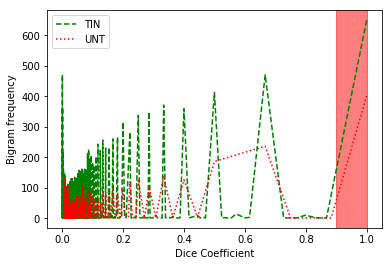

In [126]:
from scipy import arange
counts = dice_distribution(z[:,0], 'dice', 2)
counts2 = dice_distribution(z_bar[:,0], 'dice', 2)



plt.plot(list(counts.keys()), list(counts.values()),  '--c', color='g',)
plt.plot(list(counts2.keys()), list(counts2.values()),  ':c', color='r')
plt.legend(('TIN', 'UNT'),
           loc='upper left')
plt.axvspan(0.9, 1, color='red', alpha=0.5)
#plt.plot(year, pop_india, color='orange')
plt.xlabel('Dice Coefficient')
plt.ylabel('Bigram frequency')
plt.savefig('dice_dist.png')
plt.show()



In [45]:
trainX = one_hot_encoding(X[:,0], z[:,0], 'dice', 2,0.9)

1.0
0.00038887808671981335
['10mile radius', '20gauge winchester', '2adefenders trumptime', 'abbott’s meetings', 'accurate metaphor', 'accurately predict', 'achichincle lamebotas', 'adds speshul', 'adversaries aggression', 'advertisement colon']
649


In [113]:
def tokenize_and_transform(X, sample_size):
    tweet_text = {}
    tweets = X[:,0]
    arc_obj = Arc_preprocessor()
    tok_tweet = [arc_obj.tokenizeRawTweetText(doc) for doc in tweets[:sample_size]]
    #tok_tweet = [word_tokenize(doc) for doc in tweets[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_tweet)
    for i,j in enumerate(X_transform):
        tweet_text[' '.join(tok_tweet[i])] = j
    return X_transform, tweet_text

In [114]:
trainX, tweet_text = tokenize_and_transform(X, 160000)

In [115]:
count = 0
for k,v in tweet_text.items():
    print(k,v)
    count += 1
    if count == 2:
        break


@USER She should ask a few native Americans what their take on this is . [-1.98266667e-02 -8.30933333e-02 -2.94600000e-02 -6.50800000e-02
 -3.42266667e-02  1.66533333e-02 -6.03000000e-02 -6.33333333e-04
  7.57133333e-02 -6.05200000e-02  1.32466667e-02  1.32386667e-01
  4.71600000e-02 -2.11533333e-02  1.01200000e-02  5.73333333e-03
 -7.88600000e-02  6.24000000e-02  4.00000000e-05  8.28000000e-03
 -4.21266667e-02  3.67400000e-02 -2.44800000e-02 -3.62600000e-02
 -3.61133333e-02 -7.00333333e-02 -3.22933333e-02 -4.84200000e-02
  9.74000000e-03  4.11066667e-02 -6.16533333e-02 -4.84066667e-02
  5.24000000e-03 -1.27253333e-01 -3.65600000e-02 -7.20933333e-02
  4.30000000e-03 -8.35600000e-02  2.47800000e-02  5.98533333e-02
 -7.80000000e-03  8.88800000e-02 -2.77800000e-02  4.41200000e-02
 -2.48000000e-03 -7.82733333e-02  1.05120000e-01 -2.55000000e-02
  3.03600000e-02  9.24200000e-02 -2.92000000e-03 -8.39933333e-02
  2.95600000e-01  3.67066667e-02  1.38533333e-02 -3.21200000e-02
 -2.69666667e-02 

In [83]:
scaler = StandardScaler()
trainX = scaler.fit_transform(trainX)

In [ ]:
import string
table = str.maketrans('', '', string.punctuation)
tweets = z_bar[:,0]
print(len(tweets))
arc_obj = Arc_preprocessor()
tok_tweet = [arc_obj.tokenizeRawTweetText(doc) for doc in tweets]
#print(tok_tweet[:10])
textWords = ' '.join([w.translate(table).lower() for w in [' '.join(doc) for doc in tok_tweet]]).split()
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
textWords = [x  for x in textWords if not x.isdigit()]
textWords = [x  for x in textWords if not x=='user']
#textWords = [x  for x in textWords if len(x) > 2]
finder = BigramCollocationFinder.from_words(textWords)
finder2 = TrigramCollocationFinder.from_words(textWords)
scored = finder2.score_ngrams(trigram_measures.likelihood_ratio)
def takeSecond(elem):
    return elem[1]
#sorted_score = sorted([score for bigram, score in scored], reverse=True)
sorted_score = sorted( scored, reverse=True, key=takeSecond)
count = 0
for sc in [score for bigram, score in scored]:
    if sc == 1.0:
        count += 1
print(count)
print(sorted_score[:20])
print(len(sorted_score))
#print(finder.nbest(BigramAssocMeasures.pmi, 20))
tweets = z[:,0]
print(len(tweets))
arc_obj = Arc_preprocessor()
tok_tweet = [arc_obj.tokenizeRawTweetText(doc) for doc in tweets]
#print(tok_tweet[:10])
textWords = ' '.join([w.translate(table).lower() for w in [' '.join(doc) for doc in tok_tweet]]).split()
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()
textWords = [x  for x in textWords if not x.isdigit()]
textWords = [x  for x in textWords if not x=='user']
#textWords = [x  for x in textWords if len(x) > 2]
finder = BigramCollocationFinder.from_words(textWords)
finder2 = TrigramCollocationFinder.from_words(textWords)
scored = finder2.score_ngrams(trigram_measures.likelihood_ratio)
def takeSecond(elem):
    return elem[1]
#sorted_score = sorted([score for bigram, score in scored], reverse=True)
sorted_score = sorted( scored, reverse=True, key=takeSecond)
count = 0
for sc in [score for bigram, score in scored]:
    if sc == 1.0:
        count += 1
print(count)
print(sorted_score[:20])
print(len(sorted_score))
#print(finder.nbest(BigramAssocMeasures.pmi, 20))

In [116]:
from collections import Counter
cnt = Counter(y)
print(cnt)

Counter({'TIN': 3876, 'UNT': 524})


Time to save the vector representation of the essays.

In [117]:

le = LabelEncoder()
print(y[:10])
y = le.fit_transform(y)
print(y[:10])
#y = np.array([1 if x==0 else 0 for x in y ])
print(y[:10])

[UNT, TIN, UNT, TIN, UNT, TIN, TIN, TIN, TIN, TIN]
Categories (2, object): [TIN, UNT]
[1 0 1 0 1 0 0 0 0 0]
[1 0 1 0 1 0 0 0 0 0]


In [25]:
print(trainX[0])
trainX_1 = MinMaxScaler().fit_transform(trainX)
print(trainX_1[0])


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [62]:
from sklearn.decomposition import PCA
X_trans_pca = PCA(n_components=25).fit_transform(trainX, y[:150000])
print(X_trans_pca[0])

[-0.04435824 -0.0357242  -0.03207026 -0.00044345 -0.00073972 -0.00733312
 -0.00029799 -0.00022854 -0.06846507 -0.00456065  0.00524239 -0.00532835
 -0.00123084 -0.00510667  0.00404233  0.01205773 -0.01242155 -0.00466891
 -0.01443527  0.00225641 -0.03115529 -0.01229341 -0.05106859 -0.04018965
 -0.04189966]


In [118]:
X_train, X_test, y_train, y_test = train_test_split(trainX, y, stratify=y, random_state=0, test_size=0.20)

To prevent the positive class from dominating the negative, undersampling will be used to equalize the two classes.

In [119]:
rus = RandomOverSampler(random_state=0)
X_train, y_train = rus.fit_sample(X_train, y_train)


In [120]:
print(len(y_train), len(y_test))

6202 880


In [76]:
y_test = np.array([1 if x==0 else 0 for x in y_test ])

In [22]:
from collections import Counter
cnt = Counter(y_train)
print(cnt)

Counter({0: 419, 1: 419})


In [23]:
from collections import Counter
cnt = Counter(y_test)
print(cnt)

Counter({0: 775, 1: 105})


In [24]:
majority_class_y_pred = [0] * len(y_test)
print('Majority class Accuracy: {:3f}'.format(accuracy_score(y_test, majority_class_y_pred)))

Majority class Accuracy: 0.880682


In [65]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)


In [80]:
from collections import Counter
cnt = Counter(y_train)
print(cnt)

Counter({1: 472, 0: 472})


Let's test the dataset using default parameters and no preprocessing.

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.563654
Recall score: 0.625530
F1 score: 0.557493
AUC score: 0.625530
Confusion Metric : [[571 204]
 [ 51  54]]
Prediction Accuracy: 0.710227


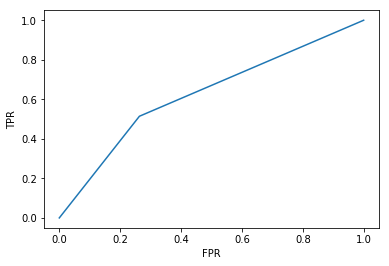

In [88]:
lr = LogisticRegression()
print_scores(lr, X_train, y_train, X_test, y_test)
plot_roc(lr, X_test, y_test)

[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.548961
Recall score: 0.595668
F1 score: 0.539843
AUC score: 0.595668
Confusion Metric : [[569 206]
 [ 57  48]]
Prediction Accuracy: 0.701136


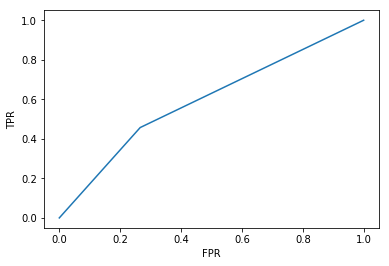

In [89]:
knn = KNeighborsClassifier()
print_scores(knn, X_train, y_train, X_test, y_test)
plot_roc(knn, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.654196
Recall score: 0.530998
F1 score: 0.531509
AUC score: 0.530998
Confusion Metric : [[764  11]
 [ 97   8]]
Prediction Accuracy: 0.877273


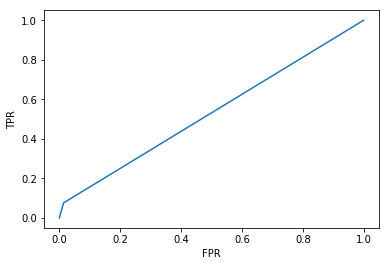

In [90]:
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
print_scores(rf, X_train, y_train, X_test, y_test)
plot_roc(rf, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
prediction   gold  tweet
0	1	@USER Hatred of the man makes people like this fool say things like this . Not reality .
0	1	@USER Calling it something different still a PAC . You are for NO BORDERS = NO COUNTRY HIGHER TAXES Gun control SOCIALIST REMOVING ICE YOU WORK FOR ILLEGALS FOR BRAC NO FAMILY TEXAS VALUES WE ARENT CALIFORNIA LIKE JONES U PPL DONT EVEN LIVE HERE . Stay in DC
1	0	@USER Fuck Alan I’m sorry
1	0	@USER omg fuck our lives sis
1	0	@USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER @USER Jaws V : When Jaws Jaws Back - Starring Kurt Chiselchest and Lorna Buxom Whud I win ? It better not be one of them laser swords ... Jess will b jealous .
0	1	@USER @USER @USER @USER Lord Of The Pies should kept his c*ck holster shut . Nobody gives a toss what you Hollyweirdo's have to say . #MAGA
0	1	@USER A dying sport
1	0	@USER Who talks shit on buff chicken dip dude it’s buff chicke

0	1	@USER You are a hero !! URL
0	1	@USER Truly . He had that sly , self-deprecating humor and swagger . Like you said , very American " . "
0	1	@USER @USER majority of DACA from 3rd world countries are communists ~ activists-Antifa-Ofa & 1 INCOMPATIBLES w/USculture&2Felons by criminal violence&participation in cult includes kill potus45 " & " destroySovereignUSA-USConstnDem'y+ replace w/marxist 4thReichNWO tyranny = TREASON "
0	1	@USER @USER @USER U don’t think bad stuff happens to men in cars ? Shit happens to everyone it’s just your mindset on how you deal with possible issues like that . You can’t spend your whole life worrying about something that most likely won’t happen to you . But it’s your life do ur thing haha .
0	1	@USER @USER @USER @USER Police reform yes . We should try that . Gun control ? We’ve tried that over and over again . It doesn’t work . But maybe it’s like socialism or communism . We just haven’t done it right yet . /Sarcasm
0	1	@USER I am a survivor of sexual a

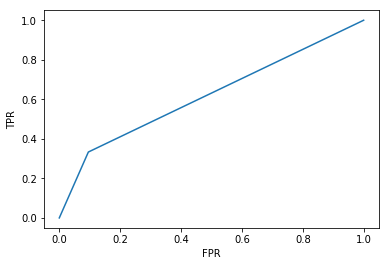

In [134]:
svc = SVC().fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test, tweet_text)

plot_roc(svc, X_test, y_test)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.440341
Recall score: 0.500000
F1 score: 0.468278
AUC score: 0.500000
Confusion Metric : [[775   0]
 [105   0]]
Prediction Accuracy: 0.880682


/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


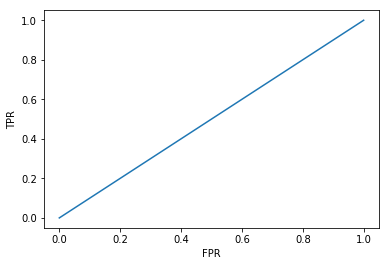

In [17]:
svc = LinearSVC().fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test)
plot_roc(svc, X_test, y_test)

[0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.559524
Recall score: 0.562919
F1 score: 0.561092
AUC score: 0.562919
Confusion Metric : [[688  87]
 [ 80  25]]
Prediction Accuracy: 0.810227


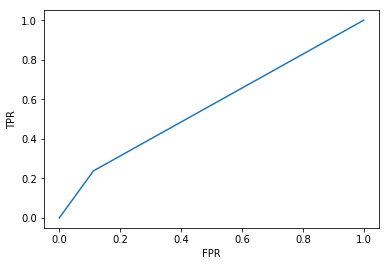

In [92]:
dtc = DecisionTreeClassifier().fit(X_train, y_train)
y_pred = dtc.predict(X_test)
print_scores(dtc, X_train, y_train, X_test, y_test)
plot_roc(dtc, X_test, y_test)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
Precision score: 0.595741
Recall score: 0.561444
F1 score: 0.571257
AUC score: 0.561444
Confusion Metric : [[730  45]
 [ 86  19]]
Prediction Accuracy: 0.851136


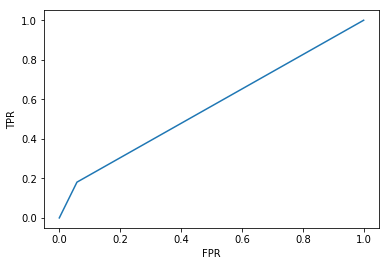

In [93]:
mlp = MLPClassifier().fit(X_train, y_train)
print_scores(mlp, X_train, y_train, X_test, y_test)
plot_roc(mlp, X_test, y_test)

Let's now use grid search and 4-fold cross validation to find the best parameters on the efficient models.

In [61]:
gs = GridSearchCV(LogisticRegression(), 
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1]}, scoring='accuracy', cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

NameError: name 'X_resample' is not defined

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[1 0 1 0 1 0 0 0 0 0]
[0 0 1 0 1 0 0 0 0 0]
Precision score: 0.567834
Recall score: 0.651837
F1 score: 0.541183
AUC score: 0.651837
Confusion Metric : [[768 395]
 [ 56 101]]
Prediction Accuracy: 0.658333


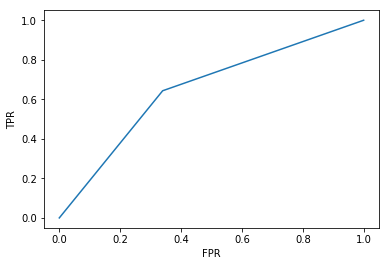

In [157]:
lrc = LogisticRegression(C=0.001)
print_scores(lrc, X_train, y_train, X_test, y_test)
plot_roc(lrc, X_test, y_test)

Comparing the RBF kernel SVC to the linear SVC there's not much of a performance difference.

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: Convergence

{'C': 0.1}
best score: 0.720975


/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


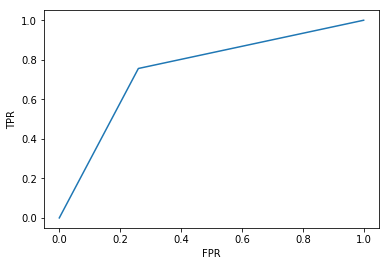

In [158]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(LinearSVC(), 
             param_grid=param_grid, scoring="accuracy", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

[0 0 1 1 1 0 1 1 1 1]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.641254
Recall score: 0.641221
F1 score: 0.641200
AUC score: 0.641221
Confusion Metric : [[83 48]
 [46 85]]


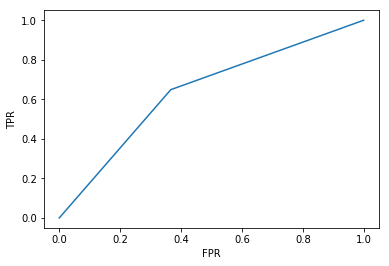

In [28]:
svc = LinearSVC(C=0.001).fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test)
plot_roc(svc, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaco

{'C': 10}
best score: 0.976393


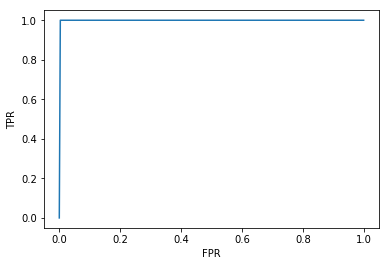

In [159]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
gs = GridSearchCV(SVC(), 
             param_grid=param_grid, scoring="accuracy", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/metrics/classification.p

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaco

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaco

{'C': 1, 'kernel': 'rbf'}
best score: 0.647792


/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureW

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaco

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaco

[0 0 1 1 1 0 0 0 0 1]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.657406
Recall score: 0.656489
F1 score: 0.655987
AUC score: 0.656489
Confusion Metric : [[91 40]
 [50 81]]


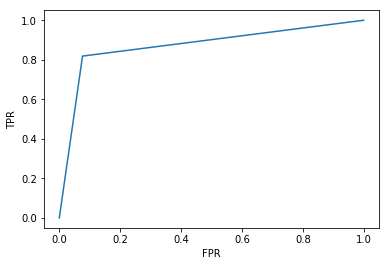

In [30]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10], 'kernel' : ['linear', 'poly', 'rbf', 'sigmoid']}
gs = GridSearchCV(SVC(), 
             param_grid=param_grid, scoring="f1", cv=4)
gs = gs.fit(X_resample, y_resample)
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)
print_scores(gs, X_train, y_train, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[0 0 1 0 1 0 0 0 0 0]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.673128
Recall score: 0.580153
F1 score: 0.515043
AUC score: 0.580153
Confusion Metric : [[124   7]
 [103  28]]


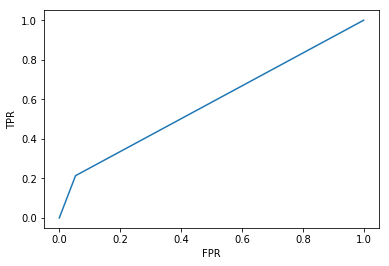

In [31]:
svc = SVC(kernel='poly').fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test)
plot_roc(svc, X_test, y_test)

{'activation': 'tanh', 'alpha': 0.001, 'learning_rate': 'adaptive', 'tol': 0.01}
best score: 0.242084


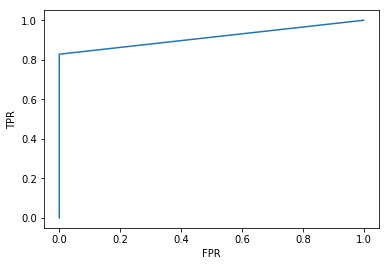

In [32]:
param_grid = {'activation': ['relu', 'logistic', 'tanh'],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate': ['constant', 'invscaling', 'adaptive'], 'tol': [0.01]}
gs = GridSearchCV(MLPClassifier(), 
             param_grid=param_grid, scoring="f1", cv=4)
gs = gs.fit(X_transform, y[:150000])
print(gs.best_params_)
print('best score: {:3f}'.format(gs.best_score_))
plot_roc(gs, X_resample, y_resample)

[0 0 1 1 1 0 1 1 1 1]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.629960
Recall score: 0.629771
F1 score: 0.629636
AUC score: 0.629771
Confusion Metric : [[85 46]
 [51 80]]


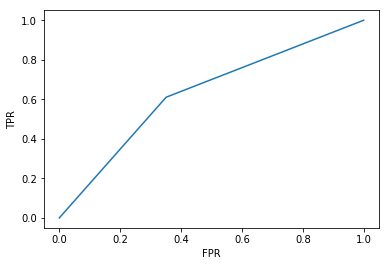

In [33]:
mlp = MLPClassifier(activation='logistic', alpha=0.001, learning_rate= 'constant', tol= 0.01).fit(X_train, y_train)
print_scores(mlp, X_train, y_train, X_test, y_test)
plot_roc(mlp, X_test, y_test)

First lets try clustering using KMeans, to see if that improves the score.

In [34]:
from sklearn.cluster import KMeans

In [35]:
X_transform_cluster = KMeans(n_clusters=10).fit_transform(X_transform, y[:150000])

In [36]:
rus = RandomUnderSampler(random_state=0)
X_resample_cluster, y_resample_cluster = rus.fit_sample(X_transform_cluster, y[:X_transform_cluster.shape[0]])

In [37]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

[0 0 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.637605
Recall score: 0.637405
F1 score: 0.637272
AUC score: 0.637405
Confusion Metric : [[86 45]
 [50 81]]


/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


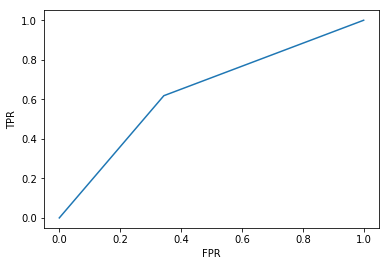

In [38]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [39]:
from sklearn.decomposition import PCA

In [40]:
X_transform_pca = PCA().fit_transform(X_transform, y[:150000])

In [41]:
rus = RandomUnderSampler(random_state=0)
X_resample_pca, y_resample_pca = rus.fit_sample(X_transform_pca, y[:X_transform_pca.shape[0]])

In [42]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_resample_cluster,
                                                    y_resample_cluster, stratify=y_resample_cluster, random_state=0)

[0 0 1 1 1 0 1 1 0 1]
[1 1 1 1 0 1 0 0 1 1]
Precision score: 0.637605
Recall score: 0.637405
F1 score: 0.637272
AUC score: 0.637405
Confusion Metric : [[86 45]
 [50 81]]


/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


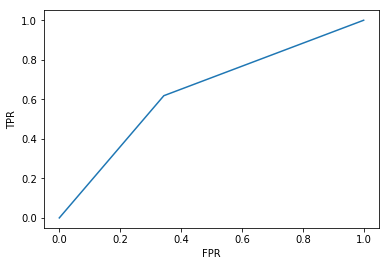

In [43]:
lr = LogisticRegression()
print_scores(lr, X_train_cluster, y_train_cluster, X_test_cluster, y_test_cluster)
plot_roc(lr, X_test_cluster, y_test_cluster)

In [44]:
test_data = pd.read_csv('/Users/aggarwalpiush/github_repos/offensivetextevaluation/data/train_data/dev.tsv', sep='\t',
                        dtype={'tweet': object,  'id': np.int32,
                              'subtask_a': 'category'})

FileNotFoundError: File b'/Users/aggarwalpiush/github_repos/offensivetextevaluation/data/train_data/dev.tsv' does not exist

In [100]:
test_data.head(3)

,qid,tweet,subtask_a
0,78209,@USER Not smearing Canadian Conservatives. Rer...,NOT
1,78210,@USER @USER @USER @USER @USER @USER @USER @USE...,NOT
2,78216,@USER Eirc Holder: a friken idiot,OFF


Now we'll load the test dataset and predict on that.

In [101]:
X = test_data[['tweet', 'subtask_a']].as_matrix()

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [102]:
X_transform = tokenize_and_transform(X, X.shape[0])

In [103]:
X_transform = scale(X_transform)
le = LabelEncoder()
y = le.fit_transform(y)
print(X_transform[:10])

[[ 1.00951626  1.78763055 -0.71630443 ... -1.59714977  0.98219342
  -1.10877258]
 [ 1.5333382  -0.7583613   0.09646049 ...  0.08484289 -1.58103886
   1.8862416 ]
 [ 0.30053237 -0.01500009  0.35636745 ... -0.87674133  0.42940762
  -0.2602455 ]
 ...
 [ 0.20232846 -0.06967081  0.23992441 ... -0.53912052  1.02528191
   1.34595972]
 [ 1.42334859  3.08964732  0.56977596 ...  4.00646155 -3.9242778
   1.70003336]
 [-1.44971484 -0.98374256 -0.96289736 ...  0.61337916  0.51588142
   1.47209888]]


In [104]:
X_transform = np.append(X_transform , np.transpose([X[:, 2]]), axis=1)

IndexError: index 2 is out of bounds for axis 1 with size 2

Now to predict the probabilities.

In [114]:
y_pred = gs.predict_proba(X_transform)[:, 0]

In [122]:
out_data = np.append(test_data[['tweet', 'subtask_a']].as_matrix(), np.transpose([y_pred]), axis=1)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [123]:
out_data.shape

(3241, 3)

In [125]:
np.savetxt('submission.csv', out_data, fmt='%s,%s, %f', delimiter=',')